In [ ]:
# Author: Anil Osman TUR

# First Glanse to the Dataset
****

In [1]:
# Necessary libraries
import numpy as np
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = 8, 6

## Statistical check from header
****

In [2]:
data_header = pd.read_csv('../data/gicsd_labels.csv', sep=', ', engine='python')
data_header.head(5)

,IMAGE_FILENAME,LABEL
0,GICSD_1_0_3.png,FULL_VISIBILITY
1,GICSD_1_0_13.png,FULL_VISIBILITY
2,GICSD_1_1_33.png,PARTIAL_VISIBILITY
3,GICSD_1_1_53.png,FULL_VISIBILITY
4,GICSD_1_2_73.png,FULL_VISIBILITY


In [3]:
data_header.describe()

,IMAGE_FILENAME,LABEL
count,800,800
unique,800,3
top,GICSD_34_3_93.png,FULL_VISIBILITY
freq,1,646


It seems that data is imbalanced. We need to see imbalance in detail

In [4]:
# see the keys to not make a key mistake
print('keys: ', data_header.keys().values)

keys:  ['IMAGE_FILENAME' 'LABEL']


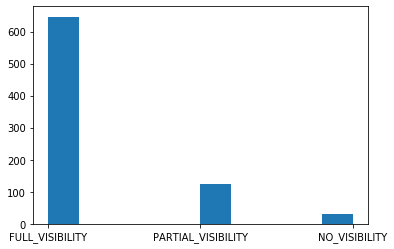

In [5]:
image_files = data_header['IMAGE_FILENAME']
labels = data_header['LABEL']
hist = labels.hist(grid=False)

We knew that the image names contain more information;
 - **GICSD_{CARD_ID}_{BACKGROUND_ID}_{IMAGE_ID}**

Let's try to read that information and get further with the balance issue

In [6]:
file_name = image_files[0].split('_')
print(file_name)

['GICSD', '1', '0', '3.png']


Creating new dataframe with these new info will make some operations easier. To make it simpler **card_id**, **background_id** and **label** can be chosen as columns

In [7]:
new_data_block = []
names = ['card_id', 'bg_id','label']
for row in zip(image_files, labels):
    file_name = row[0].split('_')
    new_data_block.append(file_name[1:-1] + [row[1]])

new_data_block = pd.DataFrame(new_data_block, columns=names)

Histograms will give us a general look to the data

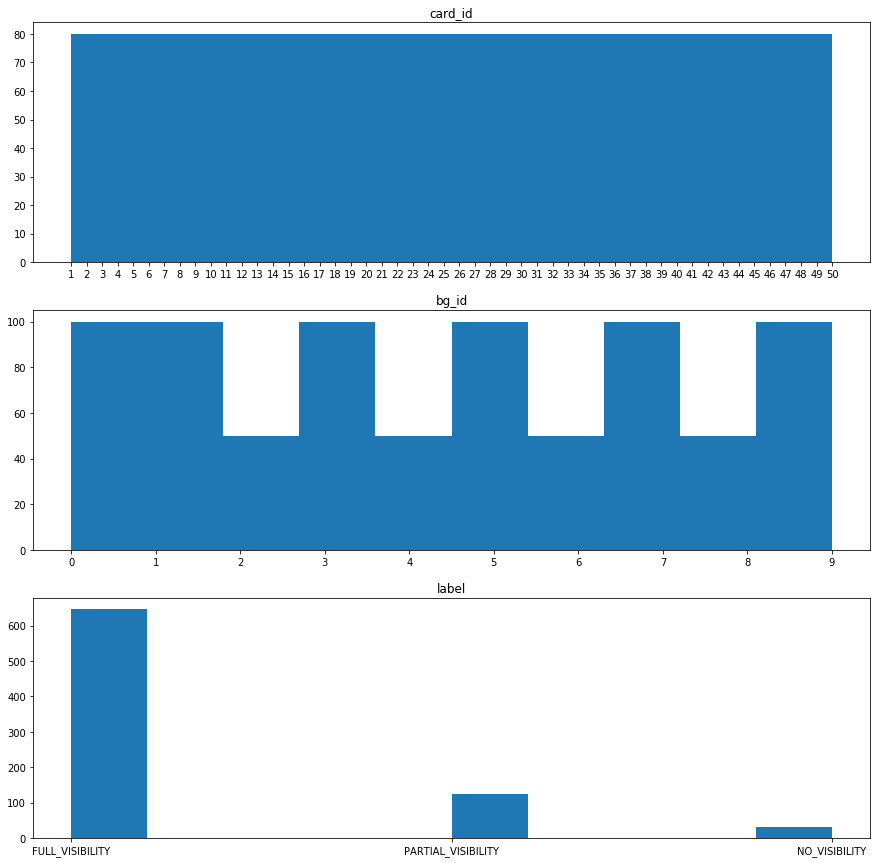

In [8]:
plt.rcParams["figure.figsize"] = 15, 15
for i, x in enumerate(names):
    plt.subplot(3,1,i+1); new_data_block[x].hist(grid=False); plt.title(x)

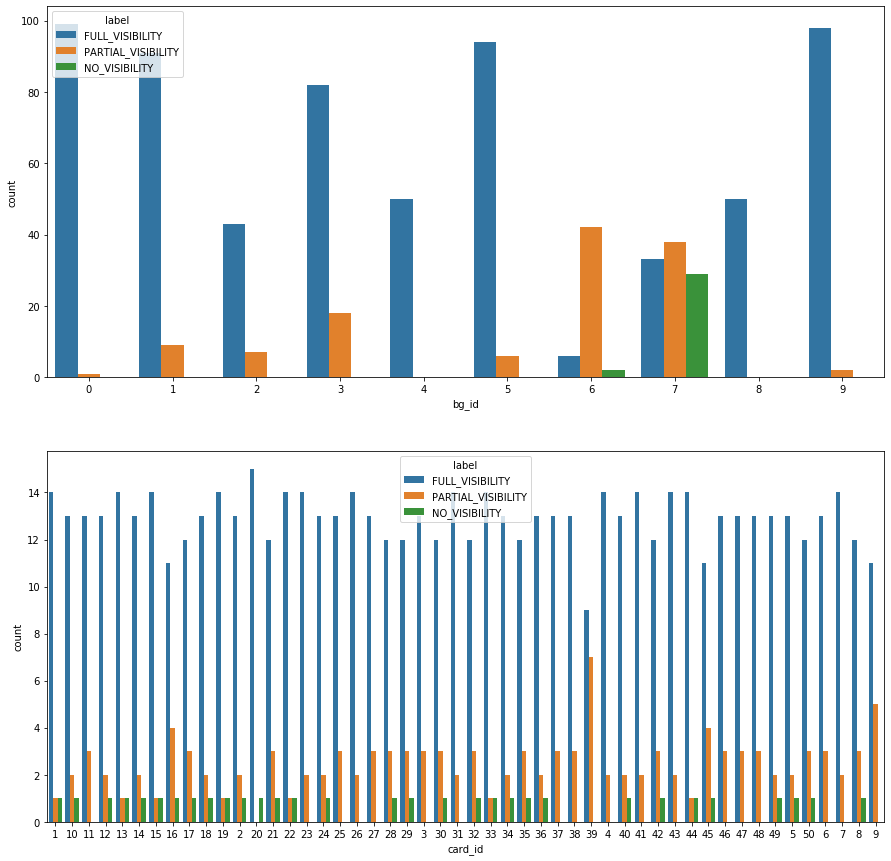

In [9]:
# a bit more detail
import seaborn as sns
plt.rcParams["figure.figsize"] = 15, 15

plt.subplot(2,1,1); sns.countplot(x='bg_id', hue='label', data=new_data_block, dodge=True);
plt.subplot(2,1,2); sns.countplot(x='card_id', hue='label', data=new_data_block, dodge=True);

Yes, we have a very imbalanced data and we need to be careful on creating train and test sets 

## Exploring the Images
****

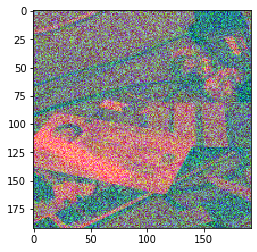

In [10]:
plt.rcParams["figure.figsize"] = 6, 4

file_path = os.path.join('../data','images', image_files[2])
image_bgr = cv2.imread(file_path)
plt.imshow(image_bgr)

Because opencv loading images as bgr, we need to convert it to rgb to see properly on plots

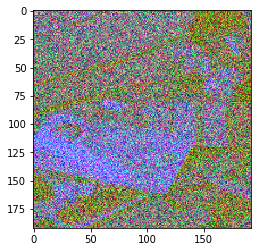

In [12]:
image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)

At this point it seems like there is a random noise in the image also meaningfull data is in a channel probably because the general color change is not random when we change the channel order. It's better to check channels seperately.

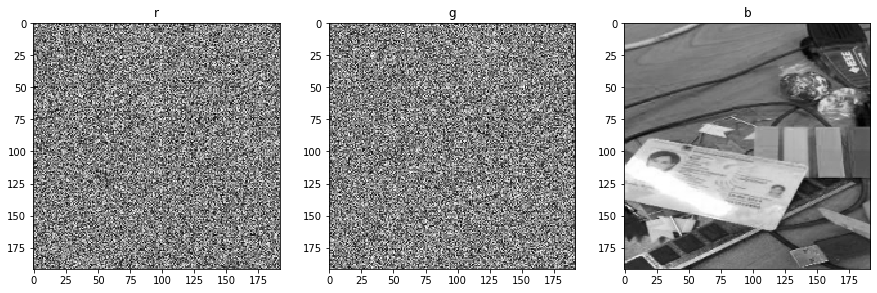

In [13]:
plt.rcParams["figure.figsize"] = 15, 15
channels = ['r', 'g', 'b']
for i, x in enumerate(channels):
    plt.subplot(1,3,i+1), plt.imshow(image_rgb[:,:,i], cmap='gray'); plt.title(x)

So it seems that we can get meaningful data from only one channel which is the **blue channel**.

In [14]:
# let's take a closer look to the channels with a help of a gui
%matplotlib qt
plt.rcParams["figure.figsize"] = 6, 4
for i, x in enumerate(channels):
    plt.figure(x + ' channel', figsize=(10,10))
    plt.imshow(image_rgb[:,:,i], cmap='gray')

It seems that the other channels only conveys random noise and we can see it in the histogram of those channels

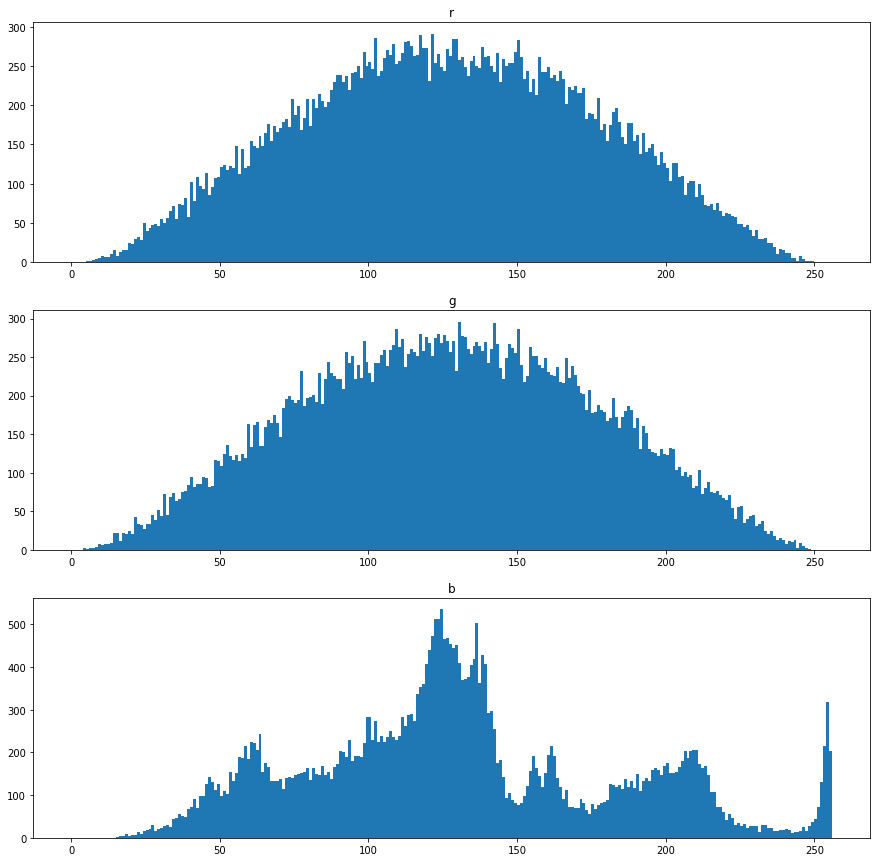

In [15]:
%matplotlib inline
plt.rcParams["figure.figsize"] = 15, 15
for i, x in enumerate(channels):
    plt.subplot(3,1,i+1),plt.hist(image_rgb[:,:,i].ravel(),256,[0,256]); plt.title(x)

After a fast check from data/images folder's contains, I will assume that only the blue channel will be usable from this sensor.

### Load some images from dataset
***
To see understand the dataset we need to see some subsamples from each background.

In [16]:
image_files = data_header['IMAGE_FILENAME']
labels = data_header['LABEL']

new_data_block = []
names = ['card_id', 'bg_id','label']
for row in zip(image_files, labels):
    file_name = row[0].split('_')
    new_data_block.append(file_name[1:-1] + [row[1]])

new_data_block = np.array(new_data_block)

In [24]:
card_id_set = sorted(list(set(new_data_block[:,0])))
bg_id_set = sorted(list(set(new_data_block[:,1])))
label_set = sorted(list(set(new_data_block[:,2])))
print('Card IDs: ', len(card_id_set), '\nBackground IDs: ', len(bg_id_set), '\nClass: ', len(label_set))

Card IDs:  50 
Background IDs:  10 
Class:  3


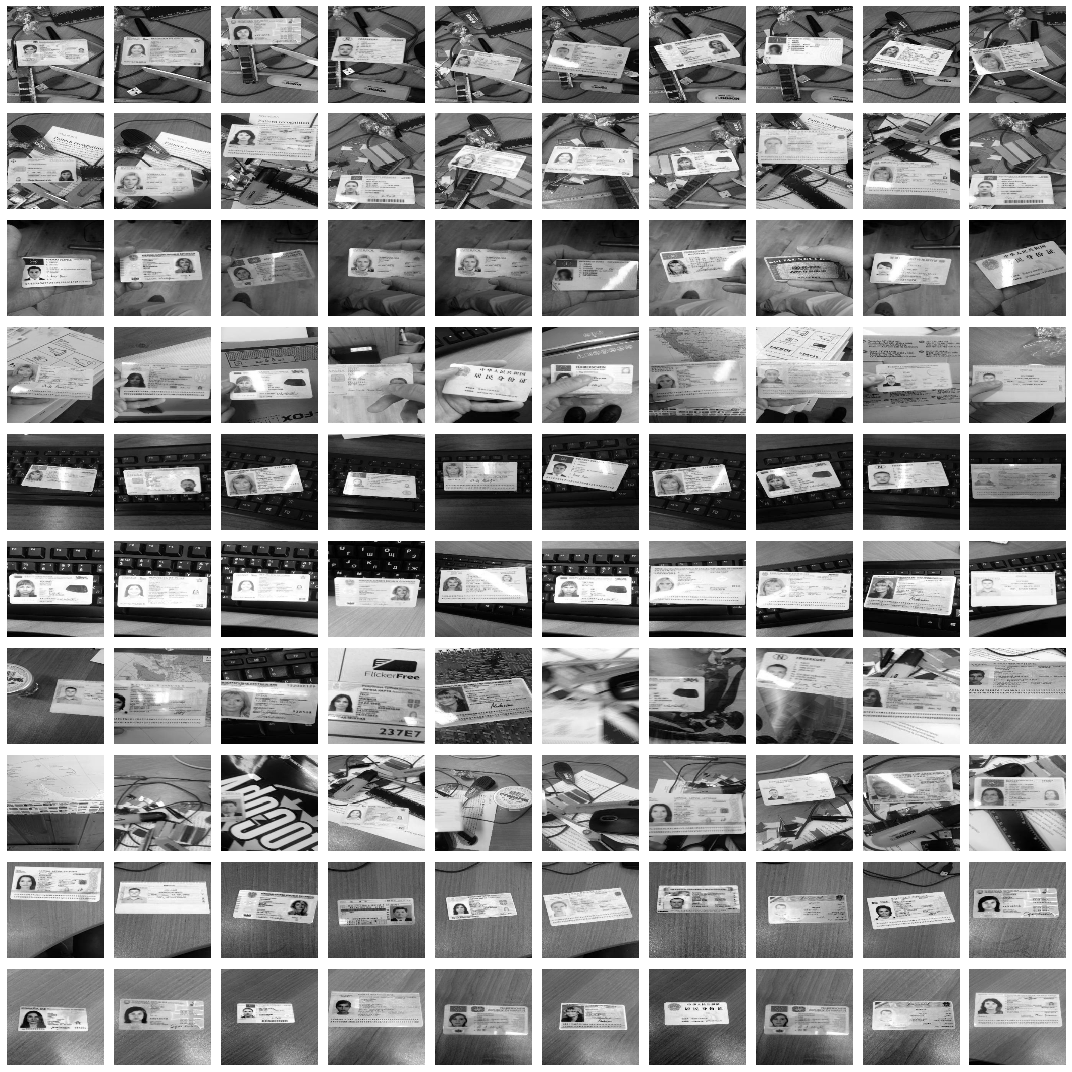

In [18]:
plt.rcParams["figure.figsize"] = 15, 15
i = 1
for bg_id in bg_id_set:
    indexes = np.where(new_data_block[:,1] == bg_id)[0]
    indexes = np.random.choice(indexes, 10)
    plt.tight_layout()
    for idx in indexes:
        file_path = os.path.join('../data','images', image_files[idx])
        image_bgr = cv2.imread(file_path)
        plt.subplot(10,10,i)
        plt.imshow(image_bgr[:,:,0], cmap='gray'); 
        plt.axis('off')
        i += 1